In [151]:
%%html
<link rel= "stylesheet" type= "text/css" href= "style.css">

# <div class = "title">Pràctica 2 <br> Classificació, detecció i Segmentació al Caltech </div>
## <div class = "sub-title">Segona pràctica d'Aprenentatge Automàtic amb xarxes neuronals</div>
### <div class = "subsub-title">Aprenentatge Automàtic 2024-25</div>

<div style="text-align: center;">
    <img src="img/portada1.jpg" align="justify" width="45%"/>
</div>

<p style="text-align: center;">ANTONI FRAU GORDIOLA - 43482642S</p>

<p style="text-align: center;">MIQUEL OLIVER ALCAYDE - 43482642S</p>

## Funcions auxiliars

<p>El primer de tot són les funcions i <em>imports</em> que ens ajudaran a llegir les dades i anotacions, tractar-les si fa falta, visualitzats, etc. També si en algun moment s'usa una funció auxiliar, es trobarà aquí. Part d'aquesta secció ha estat proporcionada pels professors i material docent.</p>

In [2]:
import os
import torch
import shutil
import random
import numpy as np
import torch.optim as optim
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from tqdm.auto import tqdm
from ultralytics import YOLO
from scipy.io import loadmat
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes

Com vorem més endavant, tenim poques imatges, per tant, consideram que és bona idea augmentar-ne el nombre. Per fer la **data augmentation**, realitzam una sèrie de transformacions aplicades a les imatges del conjunt de dades abans de guardar-les. Les transformacions definides a data_transforms són:

1. **RandomAffine**: Aplica una translació aleatòria en vertical i horitzontal amb un desplaçament de fins al 15% de la imatge original.
2. **RandomHorizontalFlip**: Realitza un flip horitzontal aleatori amb una probabilitat del 50%.
3. **ColorJitter**: Ajusta el brillantor i el contrast de la imatge dins d'un rang del 40%.
4. **ToTensor**: Converteix la imatge a un tensor, que és el format requerit per a les xarxes neuronals.
   
Aquestes transformacions augmenten la variabilitat del conjunt de dades, ajudant a prevenir el sobreajustament del model.

A continuació, el codi llegeix les imatges del conjunt de dades, aplica les transformacions de data augmentation, i guarda les imatges augmentades en una nova ubicació fent ús de *move_random_files* amb un nom modificat (per identificar la classe i l'índex de la imatge augmentada). Les imatges es guarden en subcarpetes separades per classe.

In [3]:
# Conté un condicial estrictament fals perquè no s'executin a cada vegada
if False:
    # Transformacions
    data_transforms = transforms.Compose([
        transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=None, shear=None), #Translació en vertical i horitzontal
        transforms.RandomHorizontalFlip(p=0.5),                                             # Flip horitzontal
        transforms.ColorJitter(brightness=0.4, contrast=0.4),                               # Adjust de color
        #transforms.RandomRotation(30),                                                     # Rotació fins a 30 graus (no s'aplica)
        #transforms.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0)),                     # Retall aleatori (no s'aplica)
        transforms.ToTensor()
    ])
    
    # Llegir el dataset
    dataset = ImageFolder(root="data/101_ObjectCategories/train", transform=data_transforms)
    
    output_dir = "data/101_ObjectCategories/data_augmentation"
    os.makedirs(output_dir, exist_ok=True)
    
    for i, (image, label) in enumerate(dataset):
        # Recuperar el nom de la subcarpeta (la classe de la imatge)
        class_name = dataset.classes[label]
        
        # Crear/assignar la carpeta per a cada classe
        class_folder = os.path.join(output_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)
        
        # Convertir el tensor a imatge 
        image_pil = transforms.ToPILImage()(image)
        
        # Guardar la imatge
        image_name = f"{class_name}_{i+1000}.jpg"
        image_pil.save(os.path.join(class_folder, image_name))

Una vegada creades les "noves" imatges, es mouen a ma amb el gestor d'arxius a la carpeta de *train*.

In [4]:
def move_random_files(src_dir, dest_dir, percentage):
    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    num_files_to_move = int(len(files) * percentage)

    # Selecciona fitxers aleatoris
    files_to_move = random.sample(files, num_files_to_move)

    # Mou tots els arxius sel·leccionats
    for file in files_to_move:
        src_path = os.path.join(src_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(src_path, dest_path)

In [5]:
# Conté un condicial estrictament fals perquè no s'executin a cada vegada

# Executa les vegades que facin falta la funciò anterior per crear el conjunt d'imatges de test per classe, i com
# el nombre és petit, es fa a ma
if False:
    move_random_files("data/101_ObjectCategories/train/lamp", "data/101_ObjectCategories/test/lamp", 0.3)
    move_random_files("data/101_ObjectCategories/train/dollar_bill", "data/101_ObjectCategories/test/dollar_bill", 0.3)

També sabem que una bona pràctica és normalitzar els valors de les dades d'entrada. Per **normalitzar les dades** calculam la mitjana i la desviació estàndard dels valors de les imatges per cada canal (RGB) a través del conjunt d'entrenament.

1. Inicialització dels acumuladors: Es creen variables per acumular la suma de les imatges i la suma dels seus quadrats per cada canal de color (RGB).
2. Recorregut del conjunt d’entrenament: Per cada lot d'imatges (images) del train_loader (es veu més endavant, per això executar ara aquesta funció no té gaire sentit), s'augmenten els acumuladors:
     - Suma de valors per canal: S'afegeixen els valors de cada canal (R, G, B) de cada imatge.
     - Suma dels quadrats per canal: S'afegeixen els quadrats dels valors per canal per calcular més tard la variància.
3. Càlcul de la mitjana i la desviació estàndard:
     - La mitjana es calcula com la suma dels valors de cada canal dividida pel nombre total de píxels (amplada, alçada i nombre d'imatges).
     - La desviació estàndard es calcula utilitzant la fórmula de la variància (std = sqrt(mean_squared - mean^2)), on mean_squared és la suma dels quadrats dividida pel nombre total de píxels.

Aquest procés permet obtenir els valors de mitjana i desviació estàndard de cada canal (RGB) que usarem per normalitzar les imatges, és a dir, restar la mitjana i dividir per la desviació estàndard per cada canal per assegurar que les dades estiguin en una escala similar i facilitar l'entrenament dels models.

In [6]:
# Conté un condicial estrictament fals perquè no s'executin a cada vegada
if False:
    num_samples = 0
    channel_sum = torch.zeros(3)
    channel_sum_squared = torch.zeros(3)
    
    for images, _ in train_loader:
        num_samples += images.size(0)
        channel_sum += images.sum(dim=[0, 2, 3])
        channel_sum_squared += (images ** 2).sum(dim=[0, 2, 3])
    
    mean = channel_sum / (num_samples * images.size(2) * images.size(3))
    std = torch.sqrt(channel_sum_squared / (num_samples * images.size(2) * images.size(3)) - mean ** 2)
    
    print(f"Valors de mitjanes: {mean}")
    print(f"Valos de desviació estàndard: {std}")

Ara ja no s'executa, però els valors que han resultat originalment són aquests:

<img src="img/ResultatsNormalitzacio.png" width="25%"/>

In [7]:
# Funció principal d'entrenament dels models de classificació

def train_model_sig(model, epochs, optimizer, loss_fn, train, test, show_batch=True):
    running_loss = []
    running_acc = []
    
    running_test_loss = []
    running_test_acc_cnn = []
    
    for t in tqdm(range(epochs), desc="Èpoques"):
        batch_loss = 0
        batch_acc = 0
    
        i_batch = 1
        # Iteram els batches.
        for i_batch, (x, y) in tqdm(enumerate(train), desc=f"Batches (Època {t + 1})", leave=show_batch):
            model.train()  # Posam el model a mode entranament.
    
            optimizer.zero_grad()
            
            # 1. PREDICCIÓ
            y_pred = model(x.to(device))
    
            # 2. CALCUL DE LA PÈRDUA
            # Computa la pèrdua: l'error de predicció vs el valor correcte
            # Es guarda la pèrdua en un array per futures visualitzacions
    
            loss = loss_fn(y_pred, y.to(device).float().unsqueeze(1))
    
            #3. GRADIENT
            model.zero_grad()
            loss.backward()
    
            # Actualitza els pesos utilitzant l'algorisme d'actualització
            #4. OPTIMITZACIO
            with torch.no_grad():
                optimizer.step()
    
            # 5. EVALUAM EL MODEL
            model.eval()  # Mode avaluació de la xarxa
    
            y_pred = model(x.to(device)).detach().cpu()
            batch_loss += (loss_fn(y_pred, y.float().unsqueeze(1)).detach())
    
            y_pred_class = (y_pred.detach().cpu().numpy() > 0.5)
            batch_acc += accuracy_score(y, y_pred_class)
    
        running_loss.append((batch_loss / (i_batch + 1)).cpu())
        running_acc.append(batch_acc / (i_batch + 1))
    
        batch_test_loss = 0
        batch_test_acc = 0
    
        model.eval()
        for i_batch, (x, y) in enumerate(test):
            y_pred = model(x.to(device))
            batch_test_loss += (loss_fn(y_pred, y.to(device).float().unsqueeze(1)).detach())
    
            y_pred_class = (y_pred > 0.5).double()
            batch_test_acc += accuracy_score(y, y_pred_class.cpu())
    
        running_test_loss.append((batch_test_loss / (i_batch + 1)).cpu())
        running_test_acc_cnn.append(batch_test_acc / (i_batch + 1))

    return running_loss, running_test_loss, running_acc, running_test_acc_cnn

In [8]:
# Principal funció de visualització de resultats en gràfiques de temps

def plot_train_results(running_loss, running_test_loss, running_acc, running_test_acc_cnn, name):
    plt.subplot(1,2,1)
    plt.title(f"Loss per iteració {name}")
    plt.plot(running_loss, label="train")
    plt.plot(running_test_loss, label="test")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title(f"Accuracy per iteració {name}")
    plt.plot(running_acc, label="train")
    plt.plot(running_test_acc_cnn, label="test")
    plt.legend()
    plt.show()

In [96]:
def draw_bounding_box_2(tensor, bbox, scale=[1,1], color="red", width=3):
    if not isinstance(bbox, torch.Tensor):
        y_top, y_bottom, x_left, x_right = bbox
    
        bbox = [[x_left*scale[0], y_top*scale[1], x_right*scale[0], y_bottom*scale[1]]]
        bbox = torch.tensor(bbox, dtype=torch.float32, requires_grad=True)
    
    return draw_bounding_boxes(tensor, bbox, colors=color, width=width)

# Introducció al problema

L'objectiu d'aquesta pràctica és dissenyar, entrenar i avaluar models basats en xarxes neuronals per abordar diverses tasques relacionades amb el reconeixement d'objectes en imatges. Per fer-ho, es fa servir un subconjunt de dades del **Caltech 101**, àmpliament utilitzat en investigacions relacionades amb la visió per computador i l'aprenentatge profund. El conjunt de dades inclou imatges organitzades en 101 categories d'objectes, com ara flors, animals, vehicles, electrodomèstics i altres objectes quotidians, però les tasques es faran en relació amb només dues de les classes.

En aquesta pràctica, l'enfocament se centra a treballar amb les dues categories específiques aportades pel professorat: **làmpades i bitllets de dòlar**, que de primera mà pareixen objectes visualment molt diferents. Aquest contrast serà útil tant per avaluar el rendiment dels models com per analitzar-ne els punts forts i febles en tasques específiques.

Característiques del conjunt de dades Caltech 101:
- Conté aproximadament 9.100 imatges distribuïdes en diferents categories.
- El nombre d'imatges per categoria és desigual i varia entre 40 i 800 imatges per classe, amb una mitjana aproximada de 50 imatges per categoria. Això significa que pot ser les classes no estiguin equilibrades.
- Les imatges són de resolució baixa, amb mides que oscil·len entre 200x200 i 300x300 píxels.
- Cada imatge pertany a una única categoria, cosa que simplifica l'organització de les etiquetes.

Objectiu general de la pràctica:
A partir d'aquest conjunt de dades, hem d'implementar models de xarxes neuronals capaços d'abordar les tasques següents:

1. Classificació d'objectes: Identificar correctament a quina classe pertany un objecte dins una imatge.
2. Detecció d'objectes: Localitzar la posició de l'objecte dins la imatge utilitzant bounding boxes.
3. Segmentació d'objectes: Separar l'objecte del vostre entorn, creant una màscara que destaqui la vostra àrea exacta dins la imatge.
4. Explicabilitat dels models: Aplicar mètodes d'interpretabilitat per comprendre millor les decisions preses pels models i avaluar-ne la fiabilitat. Aquest apartat és extra.

En el cas concret d'aquesta pràctica, en haver assignat les categories de làmpades i bitllets de dòlar, se cercarà explorar com els models responen davant de categories amb formes, colors i patrons visuals clarament diferenciats. Aquest contrast creim que facilitarà la comparació del rendiment dels models entrenats, tant en termes de precisió com en altres indicadors clau com el temps d'inferència, robustesa davant de dades possiblement desbalancejades i la interpretabilitat de les prediccions.

Els models que s'usaran per a les anteriors tasques són:

1. Classificació
    1. **AlexNet**: Perquè, com hem vist a l'assignatura, és una xarxa neuronal convolucional destacada, que va revolucionar el camp de l'aprenentatge profund després de guanyar el concurs ImageNet el 2012. La seva arquitectura, basada en múltiples capes convolucionals, max-pooling i activacions ReLU, la fa ideal per extreure característiques complexes de les imatges. La seva eficàcia en tasques de classificació la converteix en una excel·lent opció per fer fine-tuning i adaptar-la a les classes "làmpada" i "bitllet de dòlar". A més, creim que és una bona opció per començar, ja que ja l'hem usada a classe.
    2. **VGG11**: Perquè és una xarxa neuronal convolucional que destaca per la seva arquitectura profunda i senzilla, composta per capes convolucionals amb filtres petits i blocs seguits de max-pooling. Aquesta estructura permet extreure característiques molt detallades i jeràrquiques de les imatges, cosa que la fa especialment adequada per a tasques de classificació. A més, també és una xarxa vista a classe, pel que hem vist que el disseny modular que té facilita el fine-tuning.
    3. **ResNet50**: Aquesta perquè és una xarxa neuronal convolucional coneguda pel seu innovador disseny, basat en blocs residuals. Això permet entrenar xarxes molt profundes en solucionar el problema de l'esvaïment del gradient, facilitant que les capes aprenguin millor fins i tot en arquitectures complexes, com és aquesta i no la de 18 capes, vista a classe. Com té bona capacitat per capturar característiques detallades i fer tasques de classificació, creim que és ideal per adaptar mitjançant fine-tuning i arribar un poc més enllà a la classificació.
    4. **Custom**: També s'ha d'implementar una xarxa *custom*, de forma que segurament la farem basant-mos en altres xarxes que ja existeixen, però s'aprofundirà a l'apartat corresponent. Aquest resultat és el que veim més inesperat, ja que no tenim cap base, i poden sortir resultats molts diversos.
2. Detecció
    1. **YOLO**: És una xarxa vista a l'assignatura, i sabem que és un model extremadament ràpid i precís, dissenyat per processar imatges en temps real. A diferència d'altres mètodes, YOLO divideix la imatge en una quadrícula i prediu simultàniament les bounding boxes i les classes dels objectes, cosa que el fa eficient i adequat per a tasques on la rapidesa és clau. En aquest cas l'exercici no ho demana, però si cal fer fine-tuning, aquest model és adaptable i de forma molt senzilla.
    2. **Mask-RCNN**: Una altra xarxa vista a classe. Està a un procés intermedi, ja que té versions més antigues i més noves, com Fast-RCNN. Hem triat aquesta per la quantitat d'informació que tenim i m'hos pareixia interessant veure com es desenvolupa al problema. És un model que generalment funciona bé a la segmentació, encara que també fa la funció de detectar.
3. Segmentació
    1. **Mask-RCNN**: Una altra vegada el model anterior. Podríem haver triat un altre, però realment volem veure la diferència de rendiment del mateix model, fein una tasca o una altra.
    2. **SAM** i **YOLO**: Com a extra, veurem com es desenvolupen aquests dos models a la segmentació. El model YOLO pel mateix motiu que Mask-RCNN i rellevància dins l'evolució de la intel·ligència artificial, i el model SAM per la seva novetat, potència i facilitat d'ús.

# Primeres passes, metodologia

## Anàlisi de les dades

Primerament, definim algunes constants, com el *batch size* i el nombre d'*epochs*, que determinen la quantitat de mostres processades per cada pas d'entrenament i la durada total de l'entrenament, respectivament.

A continuació, es defineix una sèrie de transformacions d'imatge mitjançant el mòdul `transforms` de PyTorch. Aquestes transformacions inclouen el redimensionament de les imatges a una mida fixa de 224x224 píxels, la conversió de les imatges en tensors, i la normalització de les imatges per ajustar els seus valors de píxels a una escala estàndard, utilitzant mitjanes i desviacions estàndard específiques obtingudes prèviament per als tres canals de color (RGB).

Després, es carreguen els conjunts d'entrenament i prova utilitzant el conjunt de dades `ImageFolder`, ja que les imatges són organitzades per carpetes corresponents a les classes. A través del mètode `DataLoader`, les dades es carreguen en *batches* (lots) de mida 8, i es barregen per garantir una millor generalització del model durant l'entrenament. La mida triada és el resultat de diverses proves, un compromís entre generalització i especifitat de les dades que aprenen els models, i el mateix passa amb el nombre de èpoques, que és de 13.

Finalment, es configura el dispositiu per a l'entrenament, seleccionant automàticament la GPU si està disponible, o la CPU en cas contrari, per aprofitar millor el poder de càlcul en funció de les capacitats de l'equip.

In [42]:
BATCH_SIZE = 8
EPOCHS = 10

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5528, 0.5267, 0.4900], std=[0.3080, 0.3099, 0.3042])
])

train = datasets.ImageFolder('data/101_ObjectCategories/train', transform=transform)
test = datasets.ImageFolder('data/101_ObjectCategories/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


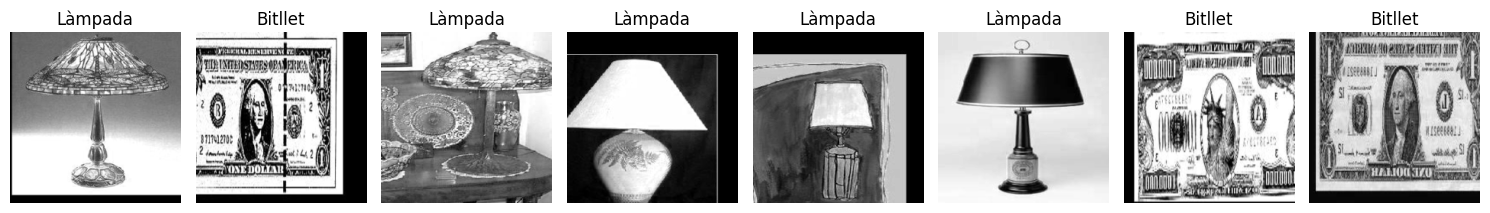

In [27]:
imgs, targets = next(iter(train_loader))
fig, axes = plt.subplots(1, BATCH_SIZE, figsize=(15, 5))
i = 0
for ax, img in zip(axes, imgs):
    ax.imshow(img[0], cmap='gray')
    ax.axis('off')
    ax.set_title("Bitllet" if targets[i] == 0 else "Làmpada")
    i += 1
    
plt.tight_layout()
plt.show()

## Models emprats

Per a realizar el treball hem fet ús de diferents models:

1. **AlexNet**
   És tracta d'una arquitectura de xarxa neuronal convolucional (CNN) que va marcar un punt d'inflexió en el camp de la visió per computador amb la seva victòria al concurs ImageNet l'any 2012. Dissenyada per a la classificació d’imatges, AlexNet és capaç d’identificar objectes en imatges gràcies a l'extracció de característiques a través de capes convolucionals. Aquesta xarxa utilitza tècniques com les funcions d’activació ReLU, el Dropout per reduir el sobreajustament, i l’entrenament paral·lel en GPUs, que la van convertir en una innovació clau del moment.
   
    Avui dia, AlexNet s’utilitza tant per a classificació com per a aprenentatge per transferència, aprofitant el coneixement adquirit en grans bases de dades per resoldre problemes més específics. A més, ha estat una base per a arquitectures més modernes. Aquest treball explora el funcionament d’AlexNet, la seva aplicació en tasques de classificació i els seus avantatges i limitacions en comparació amb models més recents. L'objectiu és comprendre com aquesta arquitectura ha contribuït al desenvolupament de les tecnologies actuals en visió artificial.

2. **VGG11**
    La classificació d'imatges amb el model VGG11 és una aplicació clau en el camp de la visió per computador. És tracta d'una xarxa neuronal convolucional dissenyada per reconèixer patrons visuals complexos en les imatges i assignar-les a categories predefinides. Aquesta arquitectura es caracteritza per la seva senzillesa i profunditat moderada, utilitzant capes convolucionals amb filtres petits de 3x3, seguides de capes de max-pooling per reduir la dimensió espacial de les dades. Tot i ser menys profunda que altres variants de la família VGG, com VGG16 o VGG19, VGG11 manté un bon equilibri entre complexitat computacional i rendiment.

    Aquesta xarxa és especialment útil per a tasques com la classificació d'objectes, gràcies a la seva capacitat de generalitzar i aprendre característiques significatives dels conjunts de dades d'entrenament. A més, VGG11 sovint es fa servir en aprenentatge per transferència, aprofitant models preentrenats en bases de dades grans com ImageNet per adaptar-los a aplicacions més específiques amb dades limitades. Aquest treball explora el funcionament de VGG11 en classificació, analitzant el procés d’entrenament, optimització i avaluació del model, així com els seus punts forts i limitacions.

3. **ResNet**
    La classificació d'imatges amb ResNet és una de les tècniques més potents en el camp de la visió per computador. ResNet (Residual Networks) introdueix una innovació clau: les connexions residuals, que permeten la creació de xarxes molt profundes sense patir del problema de l'efecte de desvaniment del gradient. Aquestes connexions ajuden que les capes profundes del model puguin aprendre millor les funcions a mesura que s’entrenen, millorant el rendiment a llarg termini. Una de les característiques destacades de ResNet és que, a mesura que augmenta la profunditat del model, aquest pot seguir entrenant de manera eficient i obtenir millors resultats en comparació amb altres arquitectures anteriors.

    Aquest model es fa servir en una àmplia gamma de tasques de classificació, com ara la detecció d'objectes i la segmentació d'imatges, gràcies a la seva capacitat per identificar patrons complexos i profunds. A més, ResNet sovint s’utilitza en aprenentatge per transferència, on un model preentrenat es pot adaptar a problemes específics amb menys dades. Aquest treball explora com funciona ResNet per a la classificació d'imatges, destacant el seu procés d'entrenament i els avantatges de les connexions residuals en models profunds.

4. **CustomNet**
    La xarxa CustomNet és una arquitectura de xarxa neuronal convolucional (CNN) pròpia dissenyada per a tasques de classificació binària. Està composta per diverses capes convolucionals que aprenen característiques espacials de les imatges d'entrada, seguides de capes de normalització i max-pooling per reduir les dimensions de les imatges i millorar l'estabilitat de l'aprenentatge. A continuació, la xarxa aplica una capa d'agrupament adaptatiu per ajustar la mida de les sortides, seguida d'una sèrie de capes totalment connectades per fer la predicció final. La sortida de la xarxa és binària, activada per una funció Sigmoid, ideal per a problemes de classificació com la detecció d'anomalies o la classificació de dues categories.

    Aquesta xarxa personalitzada podria ser útil per a aplicacions com la classificació d'imatges en tasques on es necessiti diferenciar entre dues classes, com la detecció de malalties a imatges mèdiques, la identificació de defectes en productes o la classificació de productes en comerç electrònic.

## Mètriques

Les mètriques que usam per veure el rendiment dels models són: A la classificació miram la funció de pèrdua i acerts mentre es fa el fine-tunning. Això val tant pel conjunt d'entrenament com pel conjunt de test, ja que la validació es fa amb els models en mode `.eval()`. Més endavant, es compara la millor *bouding box* del model (si en té més d'una) amb la correcta que es troba als arxius *Annotation*, i usant un algorisme de **IoU** (Intersection over Union, una tècnica molt eficaç com a funció de pèrdua a la detecció i segmentació) en el cas de detecció. En el cas de la segmentació, com no hem pogut investigar massa com arribar a una mètrica més rigorosa, ja que les dades de les imatges d'entrenament no ofereixen màsqueres, sinó contorns, es dibuixaran els resultats de la segmentació i es tria visualment quin és el més efectiu.

# Exercicis i experiments

## Classificació

### Classificació amb AlexNet

A aquest fragment, es carrega el model AlexNet preentrenat amb pesos inicialitzats. Es congelen les capes inicials de la xarxa (alex.features[0:5]) per evitar que els seus pesos s'actualitzin durant l'entrenament. Finalment, es modifica l'última capa del classificat (cap de sortida) per convertir-la en una capa Linear amb una sortida binària (1 unitat).

In [54]:
alex = models.alexnet(weights=True)
in_features = alex.classifier[6].in_features

for param in alex.features[0:5].parameters():
    param.requires_grad = False

alex.classifier[6] = torch.nn.Linear(in_features, 1)

print("Arquitectura AlexNet:")
print(alex)

C:\Users\Toni\miniconda3\envs\iaToni2024\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Arquitectura AlexNet:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_featu

A continuació, estem preparant i entrenant el model AlexNet per a una tasca de classificació binària amb la següent seqüència d'accions:

1. Enviar el model a un dispositiu específic (CPU o GPU): Transferim el model AlexNet al dispositiu seleccionat, ja que la GPU que usam accelera l'entrenament.
2. Definir la funció de pèrdua: Establim la funció de pèrdua com Binary Cross Entropy amb logits, adequada per a classificació binària.
3. Configurar l'optimitzador: Utilitzem l'optimitzador Adam amb una taxa d'aprenentatge de 1e-3 per ajustar els pesos del model.
4. Entrenar el model: Entrenem el model a través d’iteracions sobre el conjunt d’entrenament i validem el seu rendiment amb el conjunt de proves.
5. Visualitzar els resultats de l'entrenament: Generem gràfics per analitzar l'evolució de la pèrdua i l'exactitud durant l'entrenament i les proves.

Aquests passos permeten entrenar el model AlexNet, ajustar els seus pesos, i visualitzar el seu rendiment per assegurar-nos que aprèn correctament.

Èpoques:   0%|          | 0/10 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

Batches (Època 6): 0it [00:00, ?it/s]

Batches (Època 7): 0it [00:00, ?it/s]

Batches (Època 8): 0it [00:00, ?it/s]

Batches (Època 9): 0it [00:00, ?it/s]

Batches (Època 10): 0it [00:00, ?it/s]

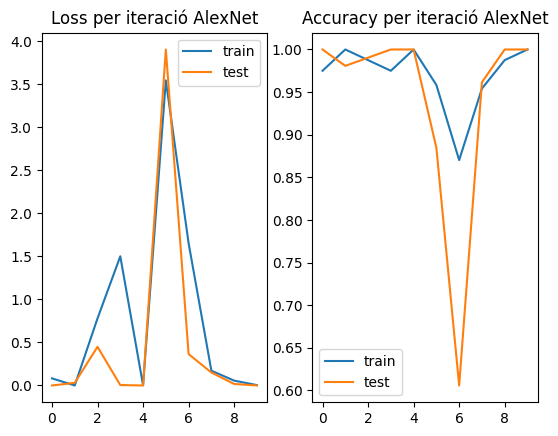

In [55]:
alex.to(device);
loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 9e-4
optimizer = optim.Adam(alex.parameters(), lr=learning_rate)

running_loss, running_test_loss, running_acc, running_test_acc_cnn = train_model_sig(alex, EPOCHS, optimizer, loss_fn, train_loader, test_loader)
plot_train_results(running_loss, running_test_loss, running_acc, running_test_acc_cnn, "AlexNet")

In [45]:
# Es troba a false perquè s'ha usat per guardar els pesos, ja no ho ha de fer
if False:
    alex_weights= alex.state_dict().copy()
    torch.save(alex_weights, "weights/alex_weights.pth")

### Classificació amb VGG11
Inicialitzem el model VGG11 amb pesos preentrenats mitjançant models.vgg11(weights=True). A continuació, modifiquem la capa de sortida (classifier[6]) per ajustar el nombre de neurones de sortida a 1, ja que estem treballant en una tasca de classificació binària. Finalment, imprimim l'arquitectura de VGG11 per veure les modificacions realitzades.

In [60]:
vgg11 = models.vgg11(weights=True)
in_features = vgg11.classifier[6].in_features
vgg11.classifier[6] = nn.Linear(in_features, 1)

print("Arquitectura vgg11:")
print(vgg11)

C:\Users\Toni\miniconda3\envs\iaToni2024\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Arquitectura vgg11:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Per ajustar el model VGG11 per a una tasca de classificació binària realizam els següents passos:

1. Congelació de les capes convolucionals: Les característiques preentrenades de les capes convolucionals de VGG11 no es modifiquen durant l'entrenament, reduint el temps de càlcul i aprofitant el coneixement existent.
2. Transferència del model al dispositiu: El model es prepara per executar-se en un dispositiu adequat, com una GPU, per millorar el rendiment.
3. Definició de la funció de pèrdua: Es fa servir Binary Cross Entropy amb logits, apropiada per a classificació binària.
4. Configuració de l’optimitzador: Es defineix l'optimitzador Adam per actualitzar els pesos amb una taxa d'aprenentatge especificada.
5. Entrenament i validació del model: S’entrena el model utilitzant un conjunt d'entrenament i es valida amb un conjunt de proves per mesurar el rendiment.
6. Visualització de resultats: Es generen gràfics que mostren l’evolució de la pèrdua i l’exactitud durant l'entrenament i la validació per analitzar-ne el comportament.

In [61]:
for param in vgg11.features.parameters():
    param.requires_grad = False

Èpoques:   0%|          | 0/10 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

Batches (Època 6): 0it [00:00, ?it/s]

Batches (Època 7): 0it [00:00, ?it/s]

Batches (Època 8): 0it [00:00, ?it/s]

Batches (Època 9): 0it [00:00, ?it/s]

Batches (Època 10): 0it [00:00, ?it/s]

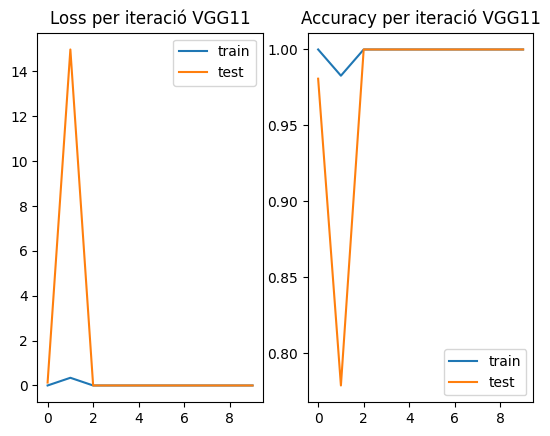

In [62]:
vgg11.to(device);
loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 1e-3
optimizer = optim.Adam(vgg11.parameters(), lr=learning_rate)

running_loss, running_test_loss, running_acc, running_test_acc_cnn = train_model_sig(vgg11, EPOCHS, optimizer, loss_fn, train_loader, test_loader)
plot_train_results(running_loss, running_test_loss, running_acc, running_test_acc_cnn, "VGG11")

In [64]:
# Es troba a false perquè s'ha usat per guardar els pesos, ja no ho ha de fer
if False:
    vgg11_weights= vgg11.state_dict().copy()
    torch.save(vgg11_weights, "weights/vgg11_weights.pth")

### Classificació amb ResNet
Inicialitzem el model ResNet50 amb pesos preentrenats mitjançant models.resnet50(weights=True). Després, modifiquem la capa de sortida (fc) per ajustar el nombre de neurones de sortida a 1, ja que estem treballant en una tasca de classificació binària. Finalment, imprimim l'arquitectura de ResNet50 per veure les modificacions realitzades.

In [65]:
resnet = models.resnet50(weights=True)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 1)

print("Arquitectura resnet:")
print(resnet)

C:\Users\Toni\miniconda3\envs\iaToni2024\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Arquitectura resnet:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

Per emprar el model ResNet per a una tasca de classificació binària amb els següents passos:

1. Enviar el model al dispositiu: El model ResNet es transfereix al dispositiu adequat (GPU o CPU) per optimitzar el rendiment de càlcul.
2. Definir la funció de pèrdua: S’utilitza Binary Cross Entropy amb logits per mesurar l’error en la classificació binària.
3. Configurar l'optimitzador: Es defineix l'optimitzador Adam per ajustar els pesos del model, amb una taxa d'aprenentatge de 1e-3.
4. Entrenament i validació: Es crida la funció d'entrenament (train_model_sig) per entrenar el model durant diverses èpoques i validar-ne el rendiment en un conjunt de prova.
5. Visualització de resultats: Es generen gràfics per mostrar l'evolució de la pèrdua i l'exactitud durant l'entrenament i les proves.

Èpoques:   0%|          | 0/10 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

Batches (Època 6): 0it [00:00, ?it/s]

Batches (Època 7): 0it [00:00, ?it/s]

Batches (Època 8): 0it [00:00, ?it/s]

Batches (Època 9): 0it [00:00, ?it/s]

Batches (Època 10): 0it [00:00, ?it/s]

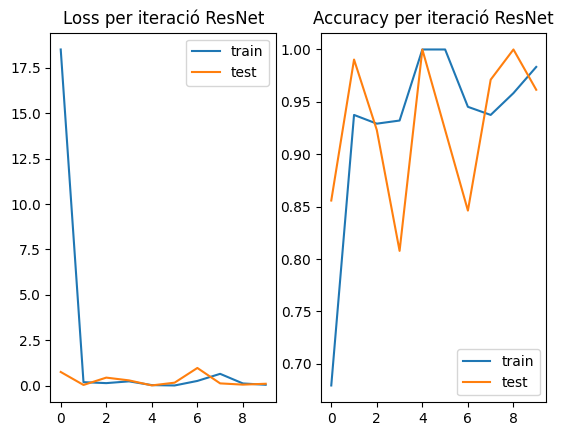

In [66]:
resnet.to(device);
loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 1e-3
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

running_loss, running_test_loss, running_acc, running_test_acc_cnn = train_model_sig(resnet, EPOCHS, optimizer, loss_fn, train_loader, test_loader)
plot_train_results(running_loss, running_test_loss, running_acc, running_test_acc_cnn, "ResNet")

In [68]:
# Es troba a false perquè s'ha usat per guardar els pesos, ja no ho ha de fer
if False:
    resnet_weights= resnet.state_dict().copy()
    torch.save(resnet_weights, "weights/resnet_weights.pth")

### Classificació amb xarxa pròpia
La xarxa pròpia que hem usat l'hem creada pensant en el propi problema de la divisió de dos objectes, però a més, com el nostre coneixement de disseny de xarxes no és molt extens, m'hos hem volgut basar en alguna ja existent i més simple o eficient, pareixent-se a la AlexNet i EfficientNet.

In [81]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 32 filtros, tamaño 3x3
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False),  # Reduce tamaño a la mitad (128x128)

            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False),  # Reduce tamaño a 64x64

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False)  # Reduce tamaño a 32x32
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(2, 20))
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),  # Ajusta el tamaño según la salida de convolución
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),  # Salida binaria
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        #x = self.avgpool(x)
        x = self.fc_layers(x)
        return x

In [89]:
custom = CustomNet()

print("Arquitectura custom:")
print(custom)

Arquitectura custom:
CustomNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(2, 20))
  (fc_layers): Sequential(
    (0): Flatten(start_d

Per a poder fer-ne us hem seguit els següents passos:

1. Enviar el model al dispositiu: El model CustomNet es transfereix al dispositiu adequat (GPU o CPU) per optimitzar el rendiment de càlcul.
2. Definir la funció de pèrdua: S’utilitza Binary Cross-Entropy amb logits per mesurar l’error en la classificació binària.
3. Configurar l'optimitzador: Es defineix l'optimitzador Adam per ajustar els pesos del model, amb una taxa d'aprenentatge de 1e-3.
4. Entrenament i validació: Es crida la funció d'entrenament (train_model_sig) per entrenar el model durant diverses èpoques i validar-ne el rendiment en un conjunt de prova.
5. Visualització de resultats: Es generen gràfics per mostrar l'evolució de la pèrdua i l'exactitud durant l'entrenament i les proves.

Èpoques:   0%|          | 0/10 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

Batches (Època 6): 0it [00:00, ?it/s]

Batches (Època 7): 0it [00:00, ?it/s]

Batches (Època 8): 0it [00:00, ?it/s]

Batches (Època 9): 0it [00:00, ?it/s]

Batches (Època 10): 0it [00:00, ?it/s]

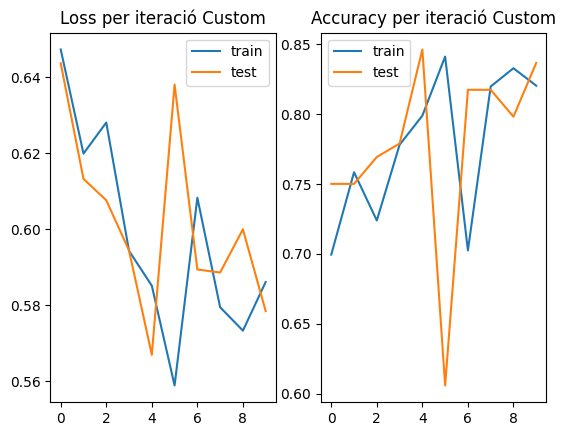

In [90]:
custom.to(device);
loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 1e-3
optimizer = optim.Adam(custom.parameters(), lr=learning_rate)

running_loss, running_test_loss, running_acc, running_test_acc_cnn = train_model_sig(custom, EPOCHS, optimizer, loss_fn, train_loader, test_loader)
plot_train_results(running_loss, running_test_loss, running_acc, running_test_acc_cnn, "Custom")

In [92]:
# Es troba a false perquè s'ha usat per guardar els pesos, ja no ho ha de fer
if False:
    custom_weights= custom.state_dict().copy()
    torch.save(custom_weights, "weights/custom_weights.pth")

## Detecció

### Detecció amb YOLO

In [93]:
yolo = YOLO("yolov8m-oiv7.pt")

In [94]:
yolo.info()
yolo = yolo.to(device)

YOLOv8m summary: 295 layers, 26,204,299 parameters, 0 gradients, 81.0 GFLOPs



0: 640x480 1 Lamp, 69.3ms
Speed: 3.1ms preprocess, 69.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 Lamp, 72.1ms
Speed: 1.5ms preprocess, 72.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x512 (no detections), 59.4ms
Speed: 3.0ms preprocess, 59.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

0: 640x448 1 Lamp, 15.1ms
Speed: 1.1ms preprocess, 15.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 Curtain, 1 Lamp, 13.8ms
Speed: 3.9ms preprocess, 13.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 (no detections), 14.5ms
Speed: 1.5ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 Animal, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x416 1 Person, 1 Poster, 13.5ms
Speed: 1.5ms preprocess, 13.5ms inference, 2.5ms postprocess p

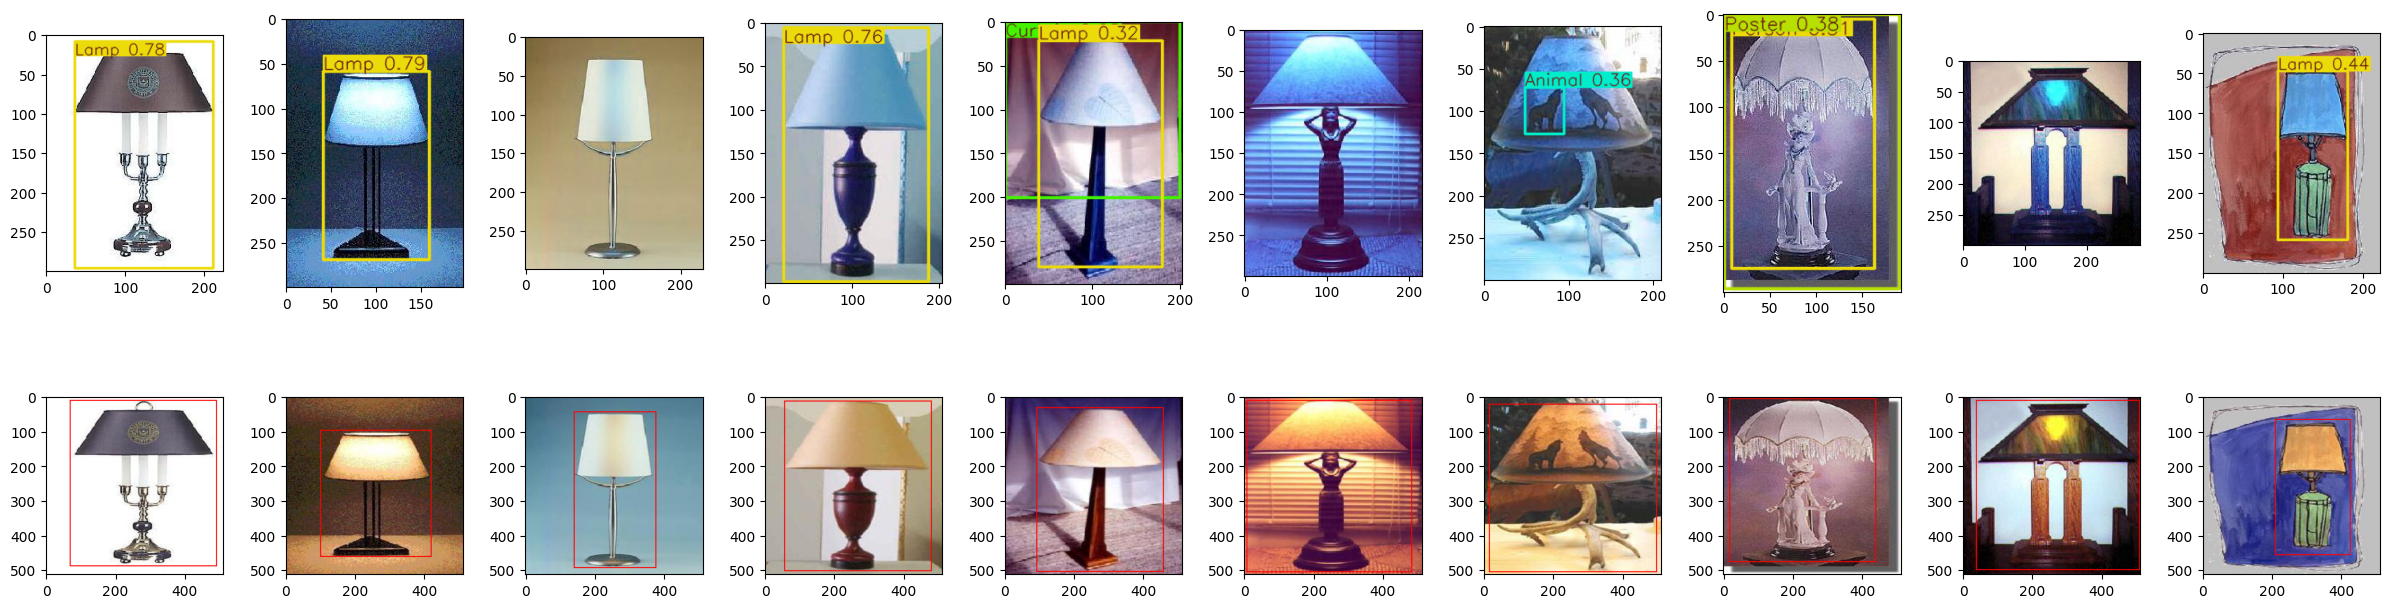

In [139]:
image_folder = "data/dataCopy/lamp"
annotation_folder = "data/dataCopy/Annotations/lamp"

image_files = sorted(f for f in os.listdir(image_folder) if f.startswith("image_") and f.endswith(".jpg"))
annotation_files = sorted(f for f in os.listdir(annotation_folder) if f.startswith("annotation_") and f.endswith(".mat"))

fig, axes = plt.subplots(2, 10, figsize=(24, 7))
i = 0

x_size = 512
y_size = 512

for image_file, annotation_file in zip(image_files, annotation_files):
    if i > 9:
        break    

    image_number = image_file.split("_")[1].split(".")[0]
    annotation_number = annotation_file.split("_")[1].split(".")[0]
    
    image = Image.open(image_folder + "/" + image_file)
    image = image.convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((y_size, x_size)),
    ])
    tensor = transform(image)[None, :, :, :]
    scale = [x_size/image.size[0], y_size/image.size[1]]
    
    results = yolo(image);
    indices = torch.tensor([1, 0, 3, 2])
    boxes = results[0].boxes.xyxy
    boxes = boxes[:, indices]
    drawn_boxes_prediction = results[0].plot()
    
    annotation = loadmat(annotation_folder + "/" + annotation_file)
    correct_box = annotation['box_coord']
    scale = [x_size/image.size[0], y_size/image.size[1]]
    drawn_boxes_correct = draw_bounding_box(tensor[0], correct_box[0], scale, color="red", width=3)
    
    axes[0, i].imshow(drawn_boxes_prediction)
    axes[1, i].imshow(drawn_boxes_correct.permute(1, 2, 0))
    i += 1

plt.tight_layout()
plt.show()

Aquí es pot veure com a la primera fila es mostren les imatges detectades pel model, mentre que a la fila de baix les que són "correctes". No sempre ho fa bé, però quan detecta la làmpada ho fa amb molta precisió (en respecte a la posció, no al valor, com es pot veure a una imatge que obté com a valor un 32% quan la làmpada és bastant similar a altres amb valors majors).


0: 416x640 1 Human face, 60.9ms
Speed: 2.1ms preprocess, 60.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 288x640 1 Human face, 1 Person, 57.2ms
Speed: 2.0ms preprocess, 57.2ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 59.5ms
Speed: 1.0ms preprocess, 59.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 (no detections), 76.5ms
Speed: 2.0ms preprocess, 76.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 288x640 (no detections), 14.2ms
Speed: 1.0ms preprocess, 14.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 (no detections), 12.2ms
Speed: 1.0ms preprocess, 12.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 1 Human face, 1 Person, 14.2ms
Speed: 1.0ms preproces

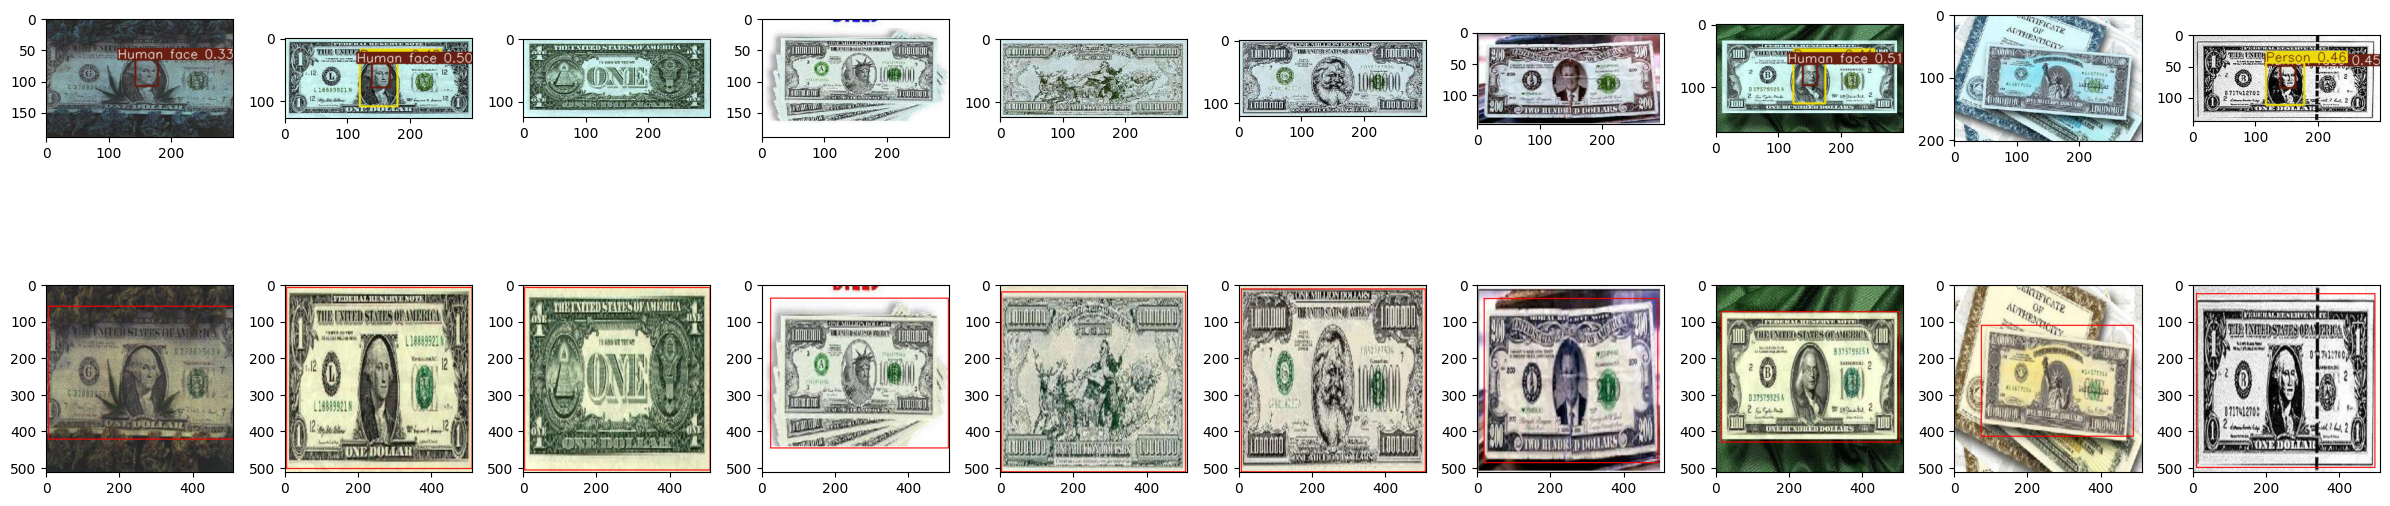

In [140]:
image_folder = "data/dataCopy/dollar_bill"
annotation_folder = "data/dataCopy/Annotations/dollar_bill"

image_files = sorted(f for f in os.listdir(image_folder) if f.startswith("image_") and f.endswith(".jpg"))
annotation_files = sorted(f for f in os.listdir(annotation_folder) if f.startswith("annotation_") and f.endswith(".mat"))

fig, axes = plt.subplots(2, 10, figsize=(24, 7))
i = 0

x_size = 512
y_size = 512

for image_file, annotation_file in zip(image_files, annotation_files):
    if i > 9:
        break    

    image_number = image_file.split("_")[1].split(".")[0]
    annotation_number = annotation_file.split("_")[1].split(".")[0]
    
    image = Image.open(image_folder + "/" + image_file)
    image = image.convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((y_size, x_size)),
    ])
    tensor = transform(image)[None, :, :, :]
    scale = [x_size/image.size[0], y_size/image.size[1]]
    
    results = yolo(image);
    indices = torch.tensor([1, 0, 3, 2])
    boxes = results[0].boxes.xyxy
    boxes = boxes[:, indices]
    drawn_boxes_prediction = results[0].plot()
    
    annotation = loadmat(annotation_folder + "/" + annotation_file)
    correct_box = annotation['box_coord']
    scale = [x_size/image.size[0], y_size/image.size[1]]
    drawn_boxes_correct = draw_bounding_box(tensor[0], correct_box[0], scale, color="red", width=3)
    
    axes[0, i].imshow(drawn_boxes_prediction)
    axes[1, i].imshow(drawn_boxes_correct.permute(1, 2, 0))
    i += 1

plt.tight_layout()
plt.show()

En aquest cas, també amb les prediccions al damunt i versions correctes a baix, veim que realment el model no té la classe bitllet de dòlar, i per tant no s'ha reconegut. Només s'han reconegut les persones o formes dels detalls. Podem preveure que no s'haurà reconegut cap dels bitllets.

### Detecció amb Mask-RCNN

In [111]:
maskrcnn = models.detection.maskrcnn_resnet50_fpn(weights=models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
maskrcnn.to(device)
maskrcnn = maskrcnn.eval();

In [112]:
def draw_bounding_box(tensor, bbox, scale=[1,1], color="red", width=3):
    if not isinstance(bbox, torch.Tensor):
        y_top, y_bottom, x_left, x_right = bbox
    
        bbox = [[x_left*scale[0], y_top*scale[1], x_right*scale[0], y_bottom*scale[1]]]
        bbox = torch.tensor(bbox, dtype=torch.float32, requires_grad=True)
    
    return draw_bounding_boxes(tensor, bbox, colors=color, width=width)

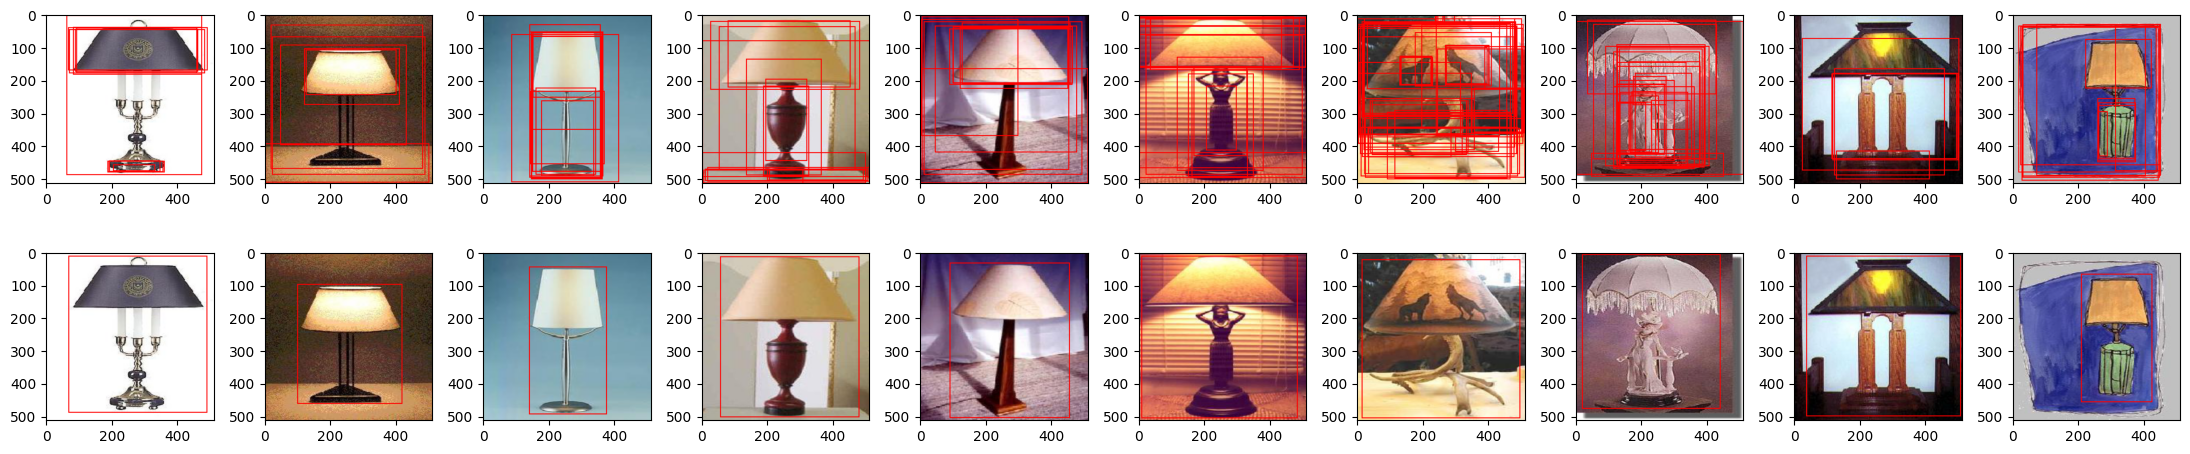

In [148]:
image_folder = "data/dataCopy/lamp"
annotation_folder = "data/dataCopy/Annotations/lamp"

image_files = sorted(f for f in os.listdir(image_folder) if f.startswith("image_") and f.endswith(".jpg"))
annotation_files = sorted(f for f in os.listdir(annotation_folder) if f.startswith("annotation_") and f.endswith(".mat"))

fig, axes = plt.subplots(2, 10, figsize=(22, 5))
i = 0

x_size = 512
y_size = 512
for image_file, annotation_file in zip(image_files, annotation_files):
    if i > 9:
        break

    image_number = image_file.split("_")[1].split(".")[0]
    annotation_number = annotation_file.split("_")[1].split(".")[0]

    image = Image.open(image_folder + "/" + image_file)    
    image = image.convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((y_size, x_size)),
    ])
    tensor = transform(image)[None, :, :, :]
    prediction_box = maskrcnn(tensor.to(device))
    drawn_boxes_prediction = draw_bounding_box(tensor[0], prediction_box[0]['boxes'], color="red", width=3)

    annotation = loadmat(annotation_folder + "/" + annotation_file)
    correct_box = annotation['box_coord']
    scale = [x_size/image.size[0], y_size/image.size[1]]
    drawn_boxes_correct = draw_bounding_box(tensor[0], correct_box[0], scale, color="red", width=3)
    
    axes[0, i].imshow(drawn_boxes_prediction.permute(1, 2, 0))
    axes[1, i].imshow(drawn_boxes_correct.permute(1, 2, 0))
    i += 1

plt.tight_layout()
plt.show()

Amb el mateix format de YOLO, les prediccions mostren vàries *bounding boxes*, entre les quals es contemplen les làmpades, per tant, els resultats poden tenir valors molt bons.

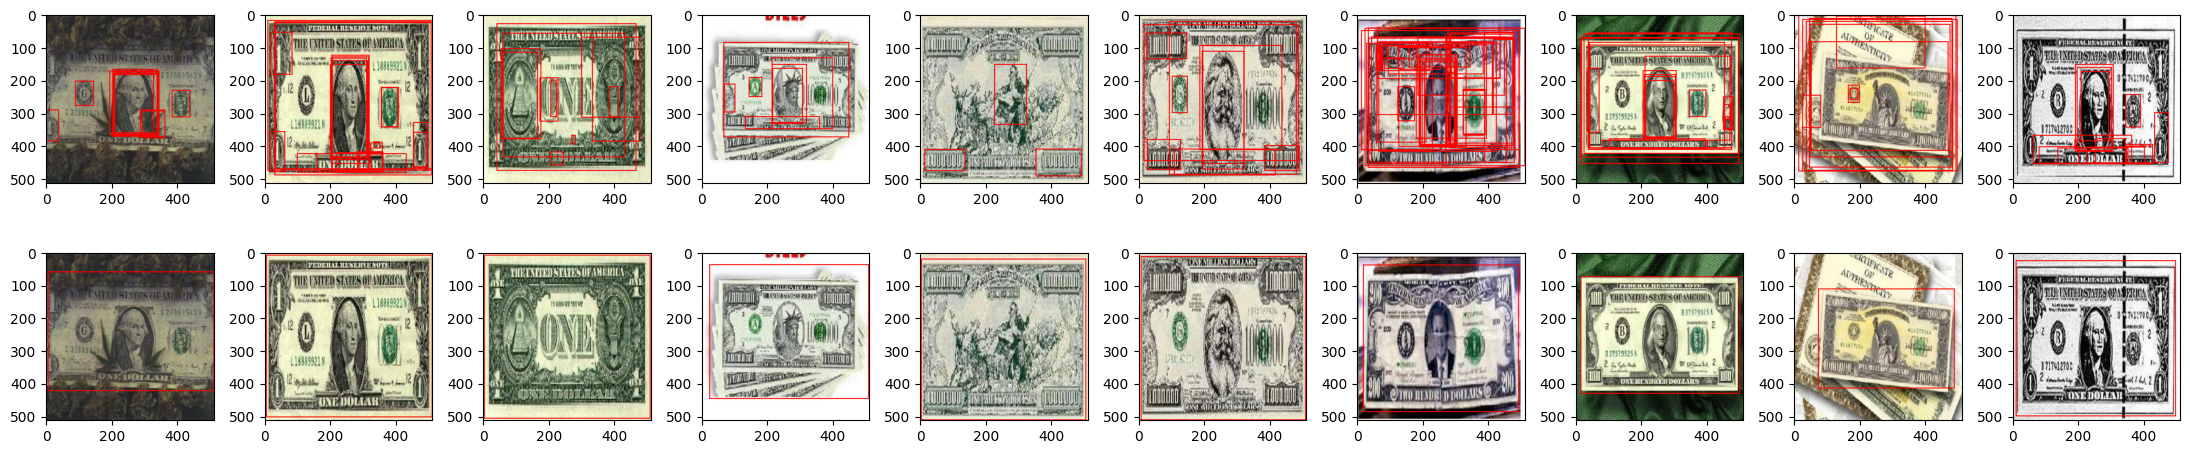

In [147]:
image_folder = "data/dataCopy/dollar_bill"
annotation_folder = "data/dataCopy/Annotations/dollar_bill"

image_files = sorted(f for f in os.listdir(image_folder) if f.startswith("image_") and f.endswith(".jpg"))
annotation_files = sorted(f for f in os.listdir(annotation_folder) if f.startswith("annotation_") and f.endswith(".mat"))

fig, axes = plt.subplots(2, 10, figsize=(22, 5))
i = 0

x_size = 512
y_size = 512
for image_file, annotation_file in zip(image_files, annotation_files):
    if i > 9:
        break

    image_number = image_file.split("_")[1].split(".")[0]
    annotation_number = annotation_file.split("_")[1].split(".")[0]

    image = Image.open(image_folder + "/" + image_file)    
    image = image.convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((y_size, x_size)),
    ])
    tensor = transform(image)[None, :, :, :]
    prediction_box = maskrcnn(tensor.to(device))
    drawn_boxes_prediction = draw_bounding_box(tensor[0], prediction_box[0]['boxes'], color="red", width=3)

    annotation = loadmat(annotation_folder + "/" + annotation_file)
    correct_box = annotation['box_coord']
    scale = [x_size/image.size[0], y_size/image.size[1]]
    drawn_boxes_correct = draw_bounding_box(tensor[0], correct_box[0], scale, color="red", width=3)
    
    axes[0, i].imshow(drawn_boxes_prediction.permute(1, 2, 0))
    axes[1, i].imshow(drawn_boxes_correct.permute(1, 2, 0))
    i += 1

plt.tight_layout()
plt.show()

Aquest cas és similar al de les làmpades també amb Mask-RCNN.

### Conclusions de detecció
El resultat de la detecció és que per a les làmpades, YOLO és més precisa però de vegades no ho detecta. Això pot ser perquè la versió és superior i té un rendiment més gran. Cal destacar que hem hagut de lliurar el model amb un dataset que no és coco (el més usat o conegut per YOLO a ultralytics) sinó amb Open Image V7, un conjunt amb major quantitat d'elements. Per què? Perquè si no l'objecte llum no estava contemplat al model, i amb aquest dataset sí. L'objecte de bitllet de dòlar no està contemplat en cap dels dos datasets, per la qual cosa mai no arriba a detectar-lo, només les persones que apareixen als mateixos bitllets. Això es podria haver arreglat fent nosaltres un entrenament amb les nostres dades sobre el model.

Pel que fa al model de Mask-RCNN, aquest arriba a detectar bé els llums (encara que al llum de dibuix agafa millor les seves parts per separat). Tot i així, és més erràtica i agafa una mica formes de tota mena. El mateix passa amb els bitllets de dòlar, agafa moltes formes i fins i tot de vegades el mateix bitllet, però no sempre. El principal problema és quan la imatge del bitllet és massa a prop, aquest acaba percebent més els seus detalls que no pas l'objecte en si. També creiem que es pot arreglar fent un entrenament sobre el model.

## Segmentació

### Segmentació amb Mask-RCNN

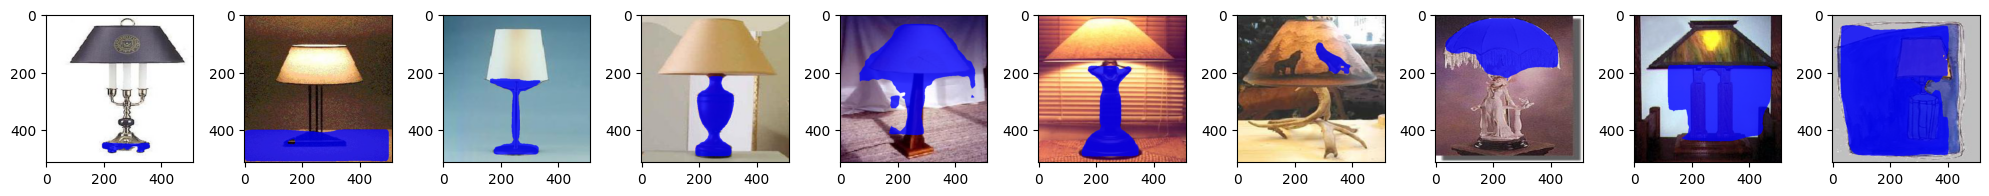

In [143]:
image_folder = "data/dataCopy/lamp"
annotation_folder = "data/dataCopy/Annotations/lamp"

image_files = sorted(f for f in os.listdir(image_folder) if f.startswith("image_") and f.endswith(".jpg"))
annotation_files = sorted(f for f in os.listdir(annotation_folder) if f.startswith("annotation_") and f.endswith(".mat"))

fig, axes = plt.subplots(1, 10, figsize=(20, 20))
i = 0

x_size = 512
y_size = 512
for image_file, annotation_file in zip(image_files, annotation_files):
    if i > 9:
        break
    
    image_number = image_file.split("_")[1].split(".")[0]
    annotation_number = annotation_file.split("_")[1].split(".")[0]

    image = Image.open(image_folder + "/" + image_file)    
    image = image.convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((y_size, x_size)),
    ])
    tensor = transform(image)[None, :, :, :]
    prediction = maskrcnn(tensor.to(device))

    mask_superposed = draw_segmentation_masks(tensor[0], masks=(prediction[0]['masks'][0, 0, :, :] > 0.5), alpha=0.8, colors="blue")
    
    axes[i].imshow(mask_superposed.permute(1, 2, 0))
    i += 1

plt.tight_layout()
plt.show()

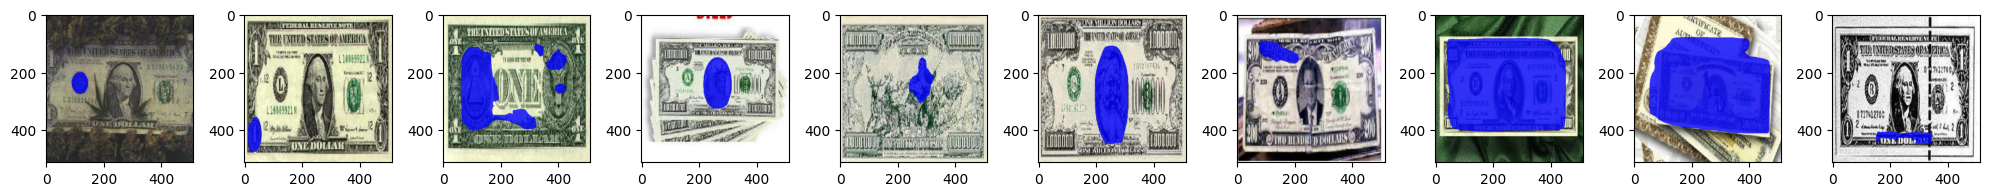

In [144]:
image_folder = "data/dataCopy/dollar_bill"
annotation_folder = "data/dataCopy/Annotations/dollar_bill"

image_files = sorted(f for f in os.listdir(image_folder) if f.startswith("image_") and f.endswith(".jpg"))
annotation_files = sorted(f for f in os.listdir(annotation_folder) if f.startswith("annotation_") and f.endswith(".mat"))

fig, axes = plt.subplots(1, 10, figsize=(20, 20))
i = 0

x_size = 512
y_size = 512
for image_file, annotation_file in zip(image_files, annotation_files):
    if i > 9:
        break
    
    image_number = image_file.split("_")[1].split(".")[0]
    annotation_number = annotation_file.split("_")[1].split(".")[0]

    image = Image.open(image_folder + "/" + image_file)    
    image = image.convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((y_size, x_size)),
    ])
    tensor = transform(image)[None, :, :, :]
    prediction = maskrcnn(tensor.to(device))

    mask_superposed = draw_segmentation_masks(tensor[0], masks=(prediction[0]['masks'][0, 0, :, :] > 0.5), alpha=0.8, colors="blue")
    
    axes[i].imshow(mask_superposed.permute(1, 2, 0))
    i += 1

plt.tight_layout()
plt.show()

### Conclusions de segmentació

Al final, en la segmentació, com en els resultats del mateix model en detecció, ha anat millor a la classe de llums que en bitllets de dòlar. Això es veu en els mateixos segments marcats de blau, ja aproximadament en 5 dels 10 llums mostrats (es podria rebuscar si més o menys) s'ha aconseguit la forma del llum. En canvi, en els bitllets de dòlar només s'ha aconseguit segmentar eficientment 1 o 2. Això va força a cord amb els resultats de la detecció, per la qual cosa fins i tot es podria intentar preveure el comportament del mateix model de YOLO també utilitzat prèviament.

# Conclusions

Les conclusions finals es poden separar en dos apartats.

## Conclusions dels experiments

Al final, en tots els experiments veiem que la classificació, la detecció i la segmentació de dues classes concretes i diferenciades és un problema que es pot resoldre i dedicar més.

Amb els resultats de la classificació estem satisfets, encara que ens hauria agradat tenir més mètriques de validació, com podria ser un altre conjunt per a aquesta validació, o un dataset més variat. Així, hem vist que les tècniques de data augmentation han servit i aconseguit resultats més robustos. Als models, veure com alguns més moderns, com ResNet, fet de blocs residuals i que aconsegueixen bons resultats amb menys recursos. També la capacitat de fer una xarxa des de zero, com la “custom” que fins i tot amb entrenament des de 0 i poques dades s'han aconseguit uns resultats en entrenament i test de més del 80%.

Amb els resultats de la detecció i encara més, la segmentació, no estem tan contents. En aquests models no hem dedicat tant afany ni fet tants experiments, com ens hauria agradat comparar amb YOLO i SAM al final, i entrenar amb el dataset proporcionat per obtenir alguns resultats a la classe de bitllet de dòlar, que no tenim. També estava previst fer servir IoU com a mètrica i no ho hem implementat, així que han estat unes comprovacions més manuals.

## Conclusions de la pràctica

Consideram que la pràctica està acabada, encara que amb algunes mancances. No hem acabat tot el que hem dit que volíem fer, ja sigui per falta de coneixement i/o temps. Ens han faltat algunes mètriques més exhaustives i rigoroses a algunes parts, així com un millor ordre i netedat al document.

# Annexos

Els diferents docuemnts amb els pesos dels models usats:

- AlexNet: https://uibes-my.sharepoint.com/:u:/g/personal/afg011_id_uib_eu/EdZPVdRO6MpFkzxXfw8iKDMBeGg-b5hIxVmqEYI24-iekg?e=3vcrXT
- VGG11: https://uibes-my.sharepoint.com/:u:/g/personal/afg011_id_uib_eu/EeWw1YjDYAZKlw5TN_mGGIgB-_jqDXTrmtdP2oo9Rx1zKw?e=AxOAzy
- ResNet50: https://uibes-my.sharepoint.com/:u:/g/personal/afg011_id_uib_eu/EQZpdShUmYJPr3FRmeq00xcB98qtW16upUasFwKX8wX3Ig?e=OkMts6
- Custom: https://uibes-my.sharepoint.com/:u:/g/personal/afg011_id_uib_eu/EfqZwHp9JjpKgWD1iMKp4xgBEbOeL70fEkiAwcrSwsHIpw?e=VybbFa